# SVM Lab (20 pts)
在本Lab中，你将学习到如何训练并使用一个SVM分类器来对数据进行分类。在完成本Lab后，你将会对SVM的dual form以及其训练算法有一个更深入的理解。请按顺序依次完成以下任务。


## 准备工作

### 环境准备

请确保完成以下依赖包的安装，并且通过下面代码来导入与验证。

In [17]:
import numpy as np
from autograder import *
from train import *
# reload modifications on imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 数据集准备

我们将使用以下zipper数据集来训练SVM分类器，并观察训练效果。

该数据集包含两个特征，以及一个标签y，其外观像是一个拉链。我们将使用SVM分类器来对数据集进行分类，预测两种类别中间的三角函数分界线。

请运行下面的代码来加载并可视化zipper dataset。

In [18]:
from dataset_generator import zipper_2D_dataset

x_train, y_train = zipper_2D_dataset(100, 100, scope=4.0)
x_test, y_test = zipper_2D_dataset(50, 50, scope=5.5) # test data is slightly out-of-distribution

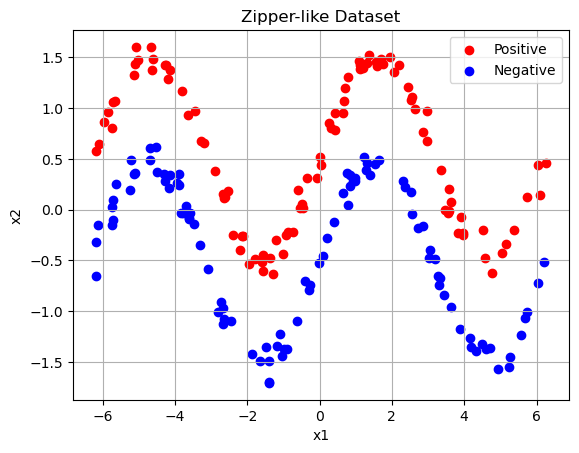

In [3]:
from vis_utils import visualize_2D_dataset

visualize_2D_dataset(x_train, y_train)

## Part 1: Support Vector Machine (6 pts)

在本部分，你将学习并完成SVM dual form的编写与训练。

在运行该部分代码前，请首先：

1. **补全`kernels.py`中三个kernel的代码；(3 pts)**

2. **补全`SVM.py`中SVM的predict函数；(3 pts)**

完成后，运行如下单元测试，检查相应分数。

In [160]:
run_kernel_tests()
run_svm_tests()

...
----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


Final Score of Kernel Functions: 3/3
Final Score of SVM predict: 3/3


## Part 2: Simplified SMO (14 pts)

为了对SVM进行训练，我们需要对以下目标函数进行优化：




\begin{aligned}
 \max_{\alpha}&\ \  W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \kappa ( x^{(i)}, x^{(j)})  \\
 \text{subject to}& \ \ 0 \leq \alpha_i \leq C, \quad i = 1, \ldots, m \\
&\ \ \sum_{i=1}^{m} \alpha_i y^{(i)} = 0
\end{aligned}


一种常用的优化SVM的算法叫做SMO，全称是序列最小优化(Sequential Minimal Optimization)。它是由Platt于1998年提出的，用于高效地解决上述的二次规划问题。

SMO采取的策略是：多次迭代优化，每一次优化时仅优化两个变量，而固定其他变量。选择两个变量的原因是因为我们有一个线性的等式约束，这使得给定一个变量，另一个变量就可以由它确定。这样，问题就简化为一个只有两个变量的优化问题，它可以通过解析方法得到解决。

SMO算法的工作流程如下：

1. 采用heuristic选择两个待优化的变量：一种常见的方法是选择违反KKT条件最严重的变量作为第一个变量，进一步选择使得目标函数值改变最大的变量作为第二个变量。

2. 固定其他变量，对这两个变量通过解析方法进行优化。

3. 检查是否所有变量都满足KKT条件：如果满足，则算法停止；否则，返回到第一步。

在实际应用中，SMO算法通过反复地选择和优化两个变量，直到整个数据集都满足KKT条件或满足一定的停止标准。由于每次都是解决一个简化的问题，SMO算法通常可以很快地收敛到最优解。



在本部分，我们将编写一种简化版的SMO算法，称为Simplified SMO。其简化之处主要在于上述工作流程中的第一步，即如何选取这两个待优化的变量上。在Simplified SMO中，我们采用的策略是：首先遍历所有的变量，找到第一个违反KKT条件的变量，然后再从所有变量中随机选择一个变量作为第二个变量。相比于SMO，Simplified SMO无法保证总是能优化到全局最优点，因为其无法保证对每一对变量都进行优化。然而，其能保证在绝大多数情况下均能收敛到不错的解。

**请你来补全SSMO.py中SSMO_optimizer.fit中的循环代码。 (fit部分代码由最后精度间接赋分)**

注意：

1. judge_violoate_KKT(), compute_E(), compute_eta(), compute_new_aj() when eta < 0, compute_b()已给出，你可以直接调用，请首先完成这些函数及其注释的阅读。
2. **compute_L_H(), compute_new_aj() when eta > 0, compute_new_ai 三个函数的代码未给出，需要你根据TODO处的要求来补全。(8 pts)**

完成后，运行如下单元测试，检查compute_L_H(), compute_new_aj() when eta > 0, compute_new_ai三个函数的正确性。

In [170]:
run_SSMO_tests()

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


Final Score of SSMO predict: 8.0/8


采用Simplified SMO算法，我们可以对SVM进行训练。请运行下面的代码进行训练。若你的代码正确，你将会看到每一个pass的loss均在单调下降。

In [177]:
from SVM import SVM
from kernels import Linear_kernel, Polynomial_kernel, RBF_kernel

kernel_fn = Linear_kernel()
svm = SVM(kernel_fn=kernel_fn)

from SSMO import SSMO_optimizer
C = 1.0
max_passes = 1000

optimizer = SSMO_optimizer(C=C)
optimizer.fit(svm, x_train, y_train, max_passes=max_passes, verbose=True)

Start training using SMO








loss: 0.0000: : 0it [00:00, ?it/s]

Training finished


训练完成后，我们可以利用训练得到的分类器来进行预测。请编写代码，计算训练集、测试集中的预测准确率。

In [178]:
y_pred = svm.predict(x_train)[1]
acc = np.sum(y_pred == y_train) / len(y_train)
print("Train accuracy: {}".format(acc))


y_pred = svm.predict(x_test)[1]
acc = np.sum(y_pred == y_test) / len(y_test)
print("Test accuracy: {}".format(acc))

Train accuracy: 0.5
Test accuracy: 0.5


可以看到，模型的预测准确率并不高。这主要是因为我们采用了**线形kernel**，而zipper数据集并不是线形可分的。为了更直观地看到我们的训练情况，请运行以下代码来查看SVM在训练集附近的分类热力图、分类边界以及测试集数据点。

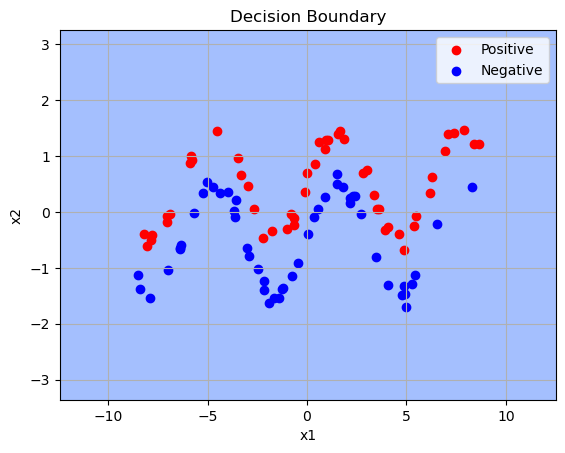

In [179]:
from vis_utils import visualize_2D_border

x1_intervals = (x_train[:, 0].min(), x_train[:, 0].max())
x2_intervals = (x_train[:, 1].min(), x_train[:, 1].max())

# expand 2.0 times
x1_mean = x1_intervals[0] + (x1_intervals[1] - x1_intervals[0]) / 2
x2_mean = x2_intervals[0] + (x2_intervals[1] - x2_intervals[0]) / 2

x1_intervals = (x1_mean - (x1_mean - x1_intervals[0]) * 2.0, x1_mean + (x1_intervals[1] - x1_mean) * 2.0)
x2_intervals = (x2_mean - (x2_mean - x2_intervals[0]) * 2.0, x2_mean + (x2_intervals[1] - x2_mean) * 2.0)

visualize_2D_border(svm, x1_intervals, x2_intervals, x_test, y_test)

接下来，请你完成`train.py`中的`train`代码，通过调整kernel类型、kernel参数、C值等来提高模型的预测准确率。

完成后，运行以下代码查看效果。**请你将训练准确率提升到99%以上，将测试集准确率提升到97%以上。（6 pts）**

In [123]:
svm = train(x_train, y_train)

y_pred = svm.predict(x_test)[1]
acc = np.sum(y_pred == y_test) / len(y_test)
print("Test accuracy: {}".format(acc))

x1_intervals = (x_train[:, 0].min(), x_train[:, 0].max())
x2_intervals = (x_train[:, 1].min(), x_train[:, 1].max())

# expand 2.0 times
x1_mean = x1_intervals[0] + (x1_intervals[1] - x1_intervals[0]) / 2
x2_mean = x2_intervals[0] + (x2_intervals[1] - x2_intervals[0]) / 2

x1_intervals = (x1_mean - (x1_mean - x1_intervals[0]) * 2.0, x1_mean + (x1_intervals[1] - x1_mean) * 2.0)
x2_intervals = (x2_mean - (x2_mean - x2_intervals[0]) * 2.0, x2_mean + (x2_intervals[1] - x2_mean) * 2.0)

visualize_2D_border(svm, x1_intervals, x2_intervals, x_test, y_test)

NameError: name 'svm' is not defined

最后，你可以运行以下代码来检查该部分分数。

In [ ]:
run_train_tests()